# Imports

In [1]:
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer

In [2]:
from sklearn.decomposition import NMF

In [3]:
import pandas as pd

In [4]:
import re

In [5]:
import nltk

In [6]:
from nltk.stem.porter import *

In [7]:
stemmer = PorterStemmer()

In [8]:
import pickle

In [9]:
import string

In [10]:
import numpy as np

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, accuracy_score, plot_confusion_matrix

In [12]:
import spacy

Uncomment this line if you do not have the en_core_web_lg spacy module downloaded.

In [13]:
# !python -m spacy download en_core_web_lg

In [14]:
nlp = spacy.load('en_core_web_lg')

In [15]:
# from google.colab import files

# Data Reading

In [16]:
#since we're using google colab to run the files, we can import the data after an upload
# uploaded = files.upload()

Saving us_election_2020_1st_presidential_debate.csv to us_election_2020_1st_presidential_debate.csv


In [116]:
df = pd.read_csv('us_election_2020_1st_presidential_debate.csv').drop('minute', axis=1)

In [117]:
df.shape

(789, 2)

In [118]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 789 entries, 0 to 788
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   speaker  789 non-null    object
 1   text     789 non-null    object
dtypes: object(2)
memory usage: 12.5+ KB


# Test processing & Cleaning

In [119]:
def read_clean(text):
    '''
    Makes text lowercase, without punctuations, numbers removed and both numbers with letters next to it too.
    Input: 
        text: string type
    Output:
        text: a transformed string in lowercase, without punctuations etc.
    '''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation),'', text)
    text = re.sub('w*\d\w', '', text)
    text = re.sub(r'[^\w]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text

In [120]:
df['text'] = df['text'].apply(read_clean)
df['speaker'].unique()

array(['Chris Wallace', 'Vice President Joe Biden',
       'President Donald J. Trump', 'Chris Wallace:'], dtype=object)

# Tokening the data with ```spacy```.

Here we create a custom tokenizer function using `spacy`. Any text cleaning that was not done using the above regex expression such as removing stopwords cna be done here. 

In [121]:
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

#list of stopwords
stop_words = spacy.lang.en.stop_words.STOP_WORDS
stop_words.update(['joe', 'biden','donal','j','s','vice',"president'",'trump','chris','wallace','mr','m','man'])

# Create our list of punctuation marks
punctuations = string.punctuation

# Load English tokenizer, tagger, parser, NER and word vectors
parser = English()

# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

#join the texts first.
def convert_list_to_string(org_list, seperator=' '):
    """ Convert list to string, by joining all item in list with given separator.
        Returns the concatenated string """
    return seperator.join(org_list)

In [122]:
df['text'] = df['text'].apply(spacy_tokenizer).apply(convert_list_to_string)
#remove empty lists
df = df[df.astype(str)['text'] != '']
df.head()

,speaker,text
0,Chris Wallace,good evening health education campus case west...
1,Chris Wallace,debate conducted health safety protocols desig...
5,Chris Wallace,gentlemen lot people waiting night let going s...
6,President Donald J. Trump,thank tell simply won election elections conse...
7,President Donald J. Trump,won election right choose people knowingly way...


In [123]:
df['speaker'] = df['speaker'].apply(lambda x: x.replace(':', ''))

In [124]:
instances = df['speaker'].value_counts()
instances

President Donald J. Trump    297
Vice President Joe Biden     234
Chris Wallace                221
Name: speaker, dtype: int64

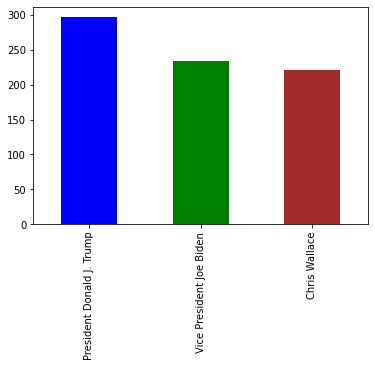

In [125]:
#visualize the speakers using a bar graph
instances.plot(kind='bar', color=['blue','green','brown']);

A point of note from previous elections is that Most of the Contenstants who spoke more words were the ones who won the elections. As we await the $3^{rd}, Nov, 2020$ to speak for itself. 



## Topic Modelling with TFIDF and NMF. 

Here-in, we try to discover the topics that each of the debate contenstance used. However, the common point of interest would be the database containing only President Donald Trump and V.P Joe Biden.Thus we will have to drop of the Moderator, Chris Wallace from out DataFrame. 

In [126]:
#new dataframe with only the President and the Vice President
new_df = df[~(df['speaker']=='Chris Wallace')]
new_df['speaker'].value_counts()

President Donald J. Trump    297
Vice President Joe Biden     234
Name: speaker, dtype: int64

In [128]:
tfidf_vectorizer = TfidfVectorizer(max_df = 0.95, min_df = 2,
                                   stop_words = 'english')
tfidf = tfidf_vectorizer.fit_transform(new_df["text"])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
nmf = NMF(n_components = 8, random_state=1, alpha=.1, l1_ratio=.5).fit(tfidf)

In [129]:
# Grab the vocubulary of words
import random
random_word_id = random.randint(0,536)

print(f'vocubulary #{random_word_id} is {tfidf_feature_names[random_word_id]}')

vocubulary #39 is beau


In [130]:
#helper function to print the topics with most of the words
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print(f"The Top 20 Words for Topic #{topic_idx}")
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [131]:
transformed_data = nmf.transform(tfidf)
len(transformed_data)

531

In [132]:
#printing the top words in the US presidential debate.
print_top_words(nmf, tfidf_feature_names, 20)

The Top 20 Words for Topic #0
true simply right deal absolutely shows dishonorably discharged rallies report idea discredited totally forest forward fortune fine fix force fixed
The Top 20 Words for Topic #1
crosstalk plan support deal favor talking president excuse evidence law place green new ask tape car remember ridiculous service delivers
The Top 20 Words for Topic #2
people want going look way open sure fact good ve like shut president safe healthcare job number don country lot
The Top 20 Words for Topic #3
said ve number opposite director fbi tape military don masks job disaster party november saying person answer way violence know
The Top 20 Words for Topic #4
know wrong doesn don like happened job fraud going got ballot view suburbs lot turn took smart son wouldn deal
The Top 20 Words for Topic #5
dollars million half millions got moscow son didn paid tens given wait billion yes mayor billions deserve gets somebody china
The Top 20 Words for Topic #6
think don good time group 

In [133]:
transformed_data[530].argmax()

6

In [135]:
new_df['Topic_Num'] = transformed_data.argmax(axis=1)
new_df.loc[28:50,['text','Topic_Num']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,Topic_Num
28,democratic party right,0
29,according harris,0
30,platform democratic party fact approved approv...,2
31,ve military people dying couldn t provide prop...,2
32,happy talk,2
33,wouldn t 0 million people late draw didn t wan...,2
35,later later,0
37,talking million people,2
38,going able shut,2
40,let finish point president opposed roe v wade ...,2


In [136]:
# Topic numbers to names
topic_num_to_name = {
    0:'Governance & White Supremacy',
    1:'Green New Deal',
    2:'National Security',
    3:'Taxation',
    4:'Fraudulent Polls',
    5:"Hunter Biden's Story",
    6:'Law Enforcement',
    7:'Racism'
}

In [137]:
topic_num_to_name = pd.DataFrame.from_dict(topic_num_to_name, orient = "index").reset_index()
topic_num_to_name.columns = ["Topic_Num", "Topic_Name"]
final_df = new_df.merge(topic_num_to_name, on = "Topic_Num")
final_df

,speaker,text,Topic_Num,Topic_Name
0,President Donald J. Trump,thank tell simply won election elections conse...,6,Law Enforcement
1,President Donald J. Trump,don t think,6,Law Enforcement
2,President Donald J. Trump,good,6,Law Enforcement
3,President Donald J. Trump,thing haven t good job fake news matter bad pr...,6,Law Enforcement
4,President Donald J. Trump,don t trust johnson johnson pfizer,6,Law Enforcement
...,...,...,...,...
526,President Donald J. Trump,oh sent marshalls killer young middle street s...,7,Racism
527,President Donald J. Trump,oh got kidding,7,Racism
528,Vice President Joe Biden,yeah,7,Racism
529,Vice President Joe Biden,yeah,7,Racism


In [144]:
final_df.groupby(['Topic_Name','speaker']).count()

text  Topic_Num
Topic_Name                   speaker                                   
Fraudulent Polls             President Donald J. Trump    24         24
                             Vice President Joe Biden     11         11
Governance & White Supremacy President Donald J. Trump    83         83
                             Vice President Joe Biden     61         61
Green New Deal               President Donald J. Trump    18         18
                             Vice President Joe Biden     20         20
Hunter Biden's Story         President Donald J. Trump    24         24
                             Vice President Joe Biden      9          9
Law Enforcement              President Donald J. Trump    15         15
                             Vice President Joe Biden      7          7
National Security            President Donald J. Trump    99         99
                             Vice President Joe Biden    107        107
Racism                       President Donald J. Trump    10         10
                             Vice President Joe Biden      5          5
Taxation                     President Donald J. Trump    24         24
                             Vice President Joe Biden     14         14